[Last time](linear-algebra-and-the-buckingham-pi-theorem.html) we showed that the Buckingham Pi theorem follows directly from one of the central results of linear algebra:
the [rank-nullity theorem](https://en.wikipedia.org/wiki/Rank%E2%80%93nullity_theorem).

The normal approach to dimensional analysis involves a certain amount of playing with the parameters, reorganizing them, and looking for their nondimensional combinations.
The understanding from a linear algebra standpoint suggests the possibility of making a computer perform dimensional analysis for you. This is not to say that the usual approach is bad. In fact, I suspect that it is still essential for getting a good intuitive feel for a set of equations.

That being said, approaching the problem from a different perspective has value, and the more ways we can understand something, the better of an understanding we have. It's said that the best way to learn something is to teach it. I suspect a similar principle applies for programming.

The main tool we will use for automating dimensional analysis will be the Python symbolic algebra package Sympy. 
It is also possible to do the same operations with the more commonly used numpy package (indeed, an early version of this article did use numpy). 
However, Sympy uses arbitrary precision arithmetic, while numpy uses floating point arithmetic, making it subject to roundoff errors.
We expect our nondimensional numbers to involve small integer powers of the parameters,
and having the answers as floating point numbers makes these integers more of a pain to identify.

Here we import Sympy, and initialize its printing system to allow for some nice typesetting of Sympy types:

In [1]:
import sympy
from IPython.display import Latex, display
sympy.init_printing()

The first step will be to describe what we mean be a parameter.
For this, we will be defining a lightweight class:

In [2]:
class Parameter(object):
    def __init__(self, symbol, units):
        self.symbol = symbol
        self.units = units

where `symbol` is a string that we will use for typesetting the final results and `units` is a Python dictionary that defines a mapping between a fundamental unit and the power of that unit in the parameter. For instance, we can define a parameter for the acceleration due to gravity $g$, which has units $\mathrm{m}/\mathrm{s}^2$ by writing

In [3]:
gravity = Parameter( 'g', {'m':1, 's':-2} )

or we can define a parameter for density $\rho$, which has units $\mathrm{kg}/\mathrm{m}^3$

In [4]:
density = Parameter( '\\rho', {'kg':1, 'm':-3})

In this instance the `symbol` string is the $\LaTeX$ symbol for $\rho$.

Okay, so we have a type defining the relevant information for a given parameter.
Now we need to be able to construct the dimension matrix described in the previous article. As a reminder, the dimension matrix is an $k$ by $n$ matrix, where $n$ is the number of parameters and $k$ is the number of fundamental units that appear in the parameters. The entries of the matrix are the exponent of the given unit in the given parameter.

The following function `construct_dimension_matrix` takes a list of `Parameter` objects. It constructs a sorted list of the fundamental units, allocates a Sympy matrix of the correct shape, and then fills the entries of the matrix:

In [5]:
def construct_dimension_matrix( parameters ):
    # Storing the units in a set means that we ignore
    # duplicate units, and will just have a set of all
    # the units which appear at least once in the problem:
    units = set()
    for p in parameters:
        for key in p.units:
            units.add(key)

    # The downside of a set is that it is unordered. It is
    # nice to have the units be alphabetized for easier 
    # inspection of the matrix, so we convert the units 
    # set to a list, then alphabetize that.
    units =list(units)
    units.sort()

    #Construct a matrix of the appropriate shape
    dimension_matrix = sympy.zeros( len(units), len(parameters) )
    
    for i,u in enumerate(units):
        for j,p in enumerate(parameters):
            # Determine the matrix entry for i,j
            # If the unit appears in the parameter,
            # then it is the power of that unit,
            # otherwise it is zero
            entry = p.units[u] if u in p.units else 0
            dimension_matrix[i,j] = entry

    return units, dimension_matrix

The function returns the list of fundamental units and the dimension matrix for the set of parameters.

As an example, we can try the case of Couette flow from the previous articles. In case you have forgotten, Couette flow involves the motion of a fluid between two plates. The fluid has a density $\rho$ and a viscosity $\eta$. The two plates are separated by a distance $D$ and the top plate is shearing the fluid with a velocity $u_0$.

![couette](images/couette.svg "I have reused this image enough that I no longer regret the time it took to make it")

We can define these parameters and their units using the `Parameter` type:

In [6]:
viscosity = Parameter( '\\eta', {'kg' : 1, 'm' : -1, 's' : -1} )
length = Parameter( 'D', {'m' : 1})
velocity = Parameter( 'u_0', {'m' : 1, 's': -1})
density = Parameter( '\\rho', {'kg':1, 'm':-3})

parameters = [density, length, velocity, viscosity]

With the parameters defined, we can give them as a list to the `construct_dimension_matrix` function and output the resulting matrix:

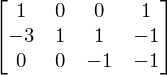

In [7]:
units, dimension_matrix = \
   construct_dimension_matrix( parameters )

dimension_matrix

As you can verify, the columns correspond to the parameters in the order in which they were given. The rows correspond to the fundamental units in alphabetical order, so the first row is kilograms, the second row is meters, and the last row is seconds. So, reading down the third row, we can see that the velocity parameter $u_0$ has units of $\mathrm{m}/\mathrm{s}$.

We learned previously that the nondimensional numbers which you can make out of the parameters provide a fundamental description of the problem. Furthermore, when we cast the problem in terms of the dimension matrix, the nondimensional numbers are precisely the set of vectors which span the nullspace of the matrix.

Thus, since we have the dimension matrix, all we have to do now is find its nullspace. Fortunately, Sympy has a function which does exactly this (sensibly named `nullspace`), thus saving us a fair amount of effort:

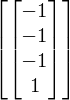

In [8]:
nullspace = dimension_matrix.nullspace()
nullspace

As we can see, the nullspace of this matrix is a single vector. This vector is a recipe for how to combine the parameters in such a way that the result has no dimensions. So the vector tells us that we have one power of $\eta$, and negative one power of each of $\rho$, $u_0$, and $D$, or

\begin{equation}
\frac{\eta}{\rho u_0 D}
\end{equation}

Which you may recognize as the inverse of the Reynolds number! Note that it makes no difference that this is the inverse of the traditionally defined Reynolds number: it is still a perfectly valid nondimensional number, and any power of it is also perfectly valid. The Reynolds number itself is just a convention for how to define the relevant nondimensional number.

At this point, we have successfuly written some code that takes some parameters, assembles the dimension matrix and finds the nondimensional numbers associated with that problem. We could be done. It would be nice, however, not to have to read parameters off of a vector of rational numbers, as we did above. Fortunately, it is not too hard to write a function that takes the a vector in the nullspace and parses it into a nice string which can be typeset via $\LaTeX$:

In [12]:
def print_nondimensional_number(parameters, nondimensional_vector):
    # Initialize two empty strings for the numerator and 
    # denominator of the nondimensional number
    numerator_string = ''
    denominator_string = ''
    
    for p,n in zip(parameters, nondimensional_vector):
        # No need to typeset the parameters if they do not 
        # appear in the nondimensional number
        if n == 0:
            continue
        # If the exponent on the parameter is one,
        # we do not need to write it.
        if n == 1 or n == -1:
            parsed_parameter = p.symbol
        # If the exponent is a whole number, we do
        # not need to represent it as a fraction.
        elif n.q == 1 or n.q == -1:
            parsed_parameter = p.symbol + '^{%i}'%(abs(n.p))
        # Otherwise, represent it as a fraction
        else:
            parsed_parameter = p.symbol + '^{%i/%i}'%(abs(n.p), abs(n.q))
    
        # Depending upon whether the exponent is positive or 
        # negative, put it in the numerator or the denominator
        if n > 0:
            numerator_string = ' '.join([numerator_string, parsed_parameter])
        elif n < 0:
            denominator_string = ' '.join([denominator_string, parsed_parameter])
        
    # If the numerator is empty, make it a one
    if numerator_string == '':
        parsed_number = '$\\frac{1}{'+denominator_string+'}$'
    # If the denominator is empty, there is no need for a fraction
    elif denominator_string == '':
        parsed_number = numerator_string
    # Otherwise make it a fraction
    else:
        parsed_number = '$\\frac{'+numerator_string+'}{'+denominator_string+'}$'
                        
    # And we are done! We can use IPython to display the LaTeX string
    display(Latex(parsed_number))

We can now use this function to typeset the Reynolds number:


In [13]:
Re = nullspace[0]
print_nondimensional_number(parameters, Re)

<IPython.core.display.Latex object>